<a href="https://colab.research.google.com/github/leihuang/scrapbook/blob/master/ConsortiumSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This notebook simulates and compares the following two architectures: 

* One with **domain-specific transformation** layers (top; referred to as "*specific*" hereafter)
* One with a **common transformation** layer (bottom; referred to as "*common*" hereafter)

In the "specific" case, features ($x_1$ and $x_2$) are sent to transformation layer $T_1$ if $d=1$ and are sent to transformation layer $T_2$ if $d=2$. Then another layer (which we tentatively call "classification layer") to output a binary classification result. 

In the "common" case, features are sent to a common transformation layer followed by a "classification layer". 

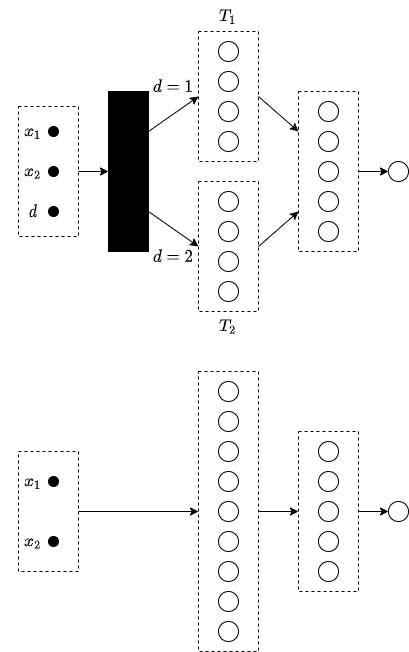

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

plt.style.use('ggplot')

In [70]:
N = 500  # (half) the sample size
EPOCHS = 2000

In [71]:
class SpecificModel(nn.Module):
    def __init__(self):
        super(SpecificModel, self).__init__()
        self.transformation1 = nn.Linear(2, 10)
        self.transformation2 = nn.Linear(2, 10)
        self.common_layer = nn.Linear(10, 1)
        
    def forward(self, x):
        d = x[:, 2]
        x = x[:, :2]
        idxs1 = d==1
        idxs2 = d==2
        x1 = x[idxs1]
        x2 = x[idxs2]
        x1 = F.relu(self.transformation1(x1))
        x2 = F.relu(self.transformation2(x2))
        x1 = self.common_layer(x1)
        x2 = self.common_layer(x2)
        logits = torch.zeros(2*N, 1)
        logits[idxs1] = x1
        logits[idxs2] = x2
        return torch.sigmoid(logits)[:,0]

In [72]:
class CommonModel(nn.Module):
    def __init__(self):
        super(CommonModel, self).__init__()
        self.transformation = nn.Linear(2, 18)
        self.common_layer = nn.Linear(18, 1)
        
    def forward(self, x):
        x = x[:, :2]
        x = F.relu(self.transformation(x))
        x = self.common_layer(x)
        return torch.sigmoid(x)[:,0]

In [73]:
model1 = SpecificModel()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

model2 = CommonModel()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

loss_fn = nn.BCELoss()

In [74]:
def get_parameter_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

get_parameter_count(model1), get_parameter_count(model2)

(71, 73)

# Make synthetic data

For domain 1 ($d=1$), $p(y=1 | x) = \text{Logistic}(x_1-x_2+0.5)$, where $\displaystyle \text{Logistic}(z) = \frac{1}{1+e^{-z}}$. 

For domain 2 ($d=2$), $p(y=1 | x) = \text{Logistic}(-x_1+x_2-0.5)$.

In [75]:
X = np.random.randn(2*N, 2)
d = np.reshape([1]*N+[2]*N, (2*N,1))
X = np.hstack((X, d))
y1 = (np.random.rand(N)<1/(1+np.exp(-(np.dot(X[:N,:2], [1,-1])+0.5)))).astype('int')
y2 = (np.random.rand(N)<1/(1+np.exp(-(np.dot(X[N:,:2], [-1,1])-0.5)))).astype('int')
y = np.concatenate((y1, y2))

X = Variable(torch.from_numpy(X)).float()
y = Variable(torch.from_numpy(y)).float()

In [76]:
losses1 = np.zeros((EPOCHS,))
accuracies1 = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y1 = model1(X)
    loss1 = loss_fn(y1, y)
    
    losses1[epoch] = loss1.item()
    
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    
    with torch.no_grad():
        y1 = model1(X)
        correct1 = ((y1>0.5).long() == y).type(torch.FloatTensor)
        accuracies1[epoch] = correct1.mean()

100%|██████████| 2000/2000 [00:03<00:00, 625.38it/s]


In [77]:
losses2 = np.zeros((EPOCHS,))
accuracies2 = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y2 = model2(X)
    loss2 = loss_fn(y2, y)

    losses2[epoch] = loss2.item()
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    
    with torch.no_grad():
        y2 = model2(X)
        correct2 = ((y2>0.5).long() == y).type(torch.FloatTensor)
        accuracies2[epoch] = correct2.mean()

100%|██████████| 2000/2000 [00:01<00:00, 1080.23it/s]


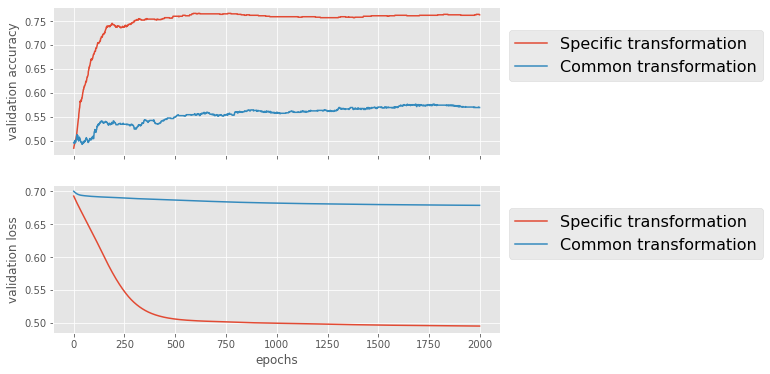

In [78]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.plot(accuracies1, label='Specific transformation')
ax1.plot(accuracies2, label='Common transformation')
ax1.legend(fontsize=16, loc=(1.02, 0.5))
ax1.set_ylabel("validation accuracy")

ax2.plot(losses1, label='Specific transformation')
ax2.plot(losses2, label='Common transformation')
ax2.legend(fontsize=16, loc=(1.02, 0.5))
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")

plt.show()